# Assess seasonality

The purpose of this notebook is to assess the impact of the seasonal cycle on the variability of tide gauges.

In [1]:
# System
import os
import sys
from datetime import datetime

# Scientific stack
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc

# Parallelization
from dask.distributed import Client, LocalCluster

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo
plt.rcParams['font.size'] = 16

# Custom
sys.path.append('..')
import attrs, utils

Load tide gauge data:

In [2]:
ds = xr.open_dataset(
    os.path.join(attrs.DATA_PATH, 'tide_gauges_1970-2017.nc')
)
ds

<xarray.Dataset>
Dimensions:             (time: 17533)
Coordinates:
  * time                (time) datetime64[ns] 1970-01-01T12:00:00 ... 2018-01...
Data variables:
    rorvik              (time) float64 ...
    marseille           (time) float64 ...
    noumea              (time) float64 ...
    midway              (time) float64 ...
    magueyes_island_pr  (time) float64 ...
    churchill           (time) float64 ...
    port_san_luis_ca    (time) float64 ...
    san_francisco_ca    (time) float64 ...
    sitka_ak            (time) float64 ...
    nain                (time) float64 ...
    san_diego           (time) float64 ...
    valparaiso          (time) float64 ...
    newport_ri          (time) float64 ...
    dzaoudzi            (time) float64 ...
    portland_me         (time) float64 ...
    la_coruna           (time) float64 ...
    johnston            (time) float64 ...
    ofunato             (time) float64 ...
    abashiri            (time) float64 ...
    taranaki            (time) float64 ...
    pago_pago           (time) float64 ...
    simons_town         (time) float64 ...
    wilmington_nc       (time) float64 ...
    cuxhaven            (time) float64 ...
    kwajalein           (time) float64 ...
    naha                (time) float64 ...
    pensacola_fl        (time) float64 ...
    wake                (time) float64 ...
    new_london_ct       (time) float64 ...
    rikitea             (time) float64 ...
    mera                (time) float64 ...
    nishinoomote        (time) float64 ...
    kahului             (time) float64 ...
    naze                (time) float64 ...
    cristobal           (time) float64 ...
    tofino              (time) float64 ...
    fernandina_beach    (time) float64 ...
    vardo               (time) float64 ...
    woods_hole_ma       (time) float64 ...
    kushimoto           (time) float64 ...
    ketchikan_ak        (time) float64 ...
    cape_may_nj         (time) float64 ...
    montauk_ny          (time) float64 ...
    victoria_bc         (time) float64 ...
    naples_fl           (time) float64 ...
    wellington          (time) float64 ...
    miyakejima          (time) float64 ...
    nawiliwili          (time) float64 ...
    mokuoloe            (time) float64 ...
    brest               (time) float64 ...
    nantucket_ma        (time) float64 ...
    tregde              (time) float64 ...
    faraday             (time) float64 ...
    toyama              (time) float64 ...
    kushiro             (time) float64 ...
    key_west_fl         (time) float64 ...
    aburatsu            (time) float64 ...
    boston_ma           (time) float64 ...
    reunion             (time) float64 ...
    adak_alaska         (time) float64 ...
    la_jolla_ca         (time) float64 ...
    tumaco              (time) float64 ...
    guam                (time) float64 ...
    lewes_de            (time) float64 ...
    crescent_city_ca    (time) float64 ...
    antofagasta         (time) float64 ...
    fort_pulaski_ga     (time) float64 ...
    maisaka             (time) float64 ...
    ishigaki            (time) float64 ...
    rockport_tx         (time) float64 ...
    fort_denison        (time) float64 ...
    hakodate            (time) float64 ...
    south_beach_or      (time) float64 ...
    wakkanai            (time) float64 ...
    ceuta               (time) float64 ...
    new_york_ny         (time) float64 ...
    prince_rupert       (time) float64 ...
    port_isabel_tx      (time) float64 ...
    yakutat_ak          (time) float64 ...
    eastport_me         (time) float64 ...
    atlantic_city       (time) float64 ...
    neah_bay_wa         (time) float64 ...
    st_petersburg_fl    (time) float64 ...
    balboa              (time) float64 ...
    hilo_hawaii         (time) float64 ...
    astoria_or          (time) float64 ...
    galveston_pier_21   (time) float64 ...
    los_angeles_ca      (time) float64 ...
    la_libertad         (time) float64 ...

Let's take a look at a few examples:

In [3]:
subset_gauges = ['new_york_ny', 'pensacola_fl', 'midway', 'brest', 'galveston_pier_21', 'ishigaki']
subset_ds = ds[subset_gauges]

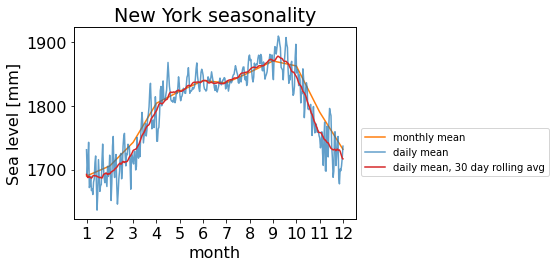

In [4]:
new_york_sl = ds['new_york_ny']
monthly_mean = new_york_sl.groupby('time.month').mean()
daily_mean = new_york_sl.groupby('time.dayofyear').mean()
daily_smoothed = daily_mean.rolling(dayofyear=30, center=True, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(8,4))
ax_top = ax.twiny()

daily_mean.plot(ax=ax_top, color='tab:blue', alpha=0.7, label='daily mean')
daily_smoothed.plot(ax=ax_top, color='tab:red', label='daily mean, smoothened')
monthly_mean.plot(ax=ax, color='tab:orange', label='monthly mean')

ax.set(
    title='New York seasonality',
    ylabel='Sea level [mm]',
    xticks=np.arange(1, 13.1, dtype=int),
)
ax_top.set(xticks=[], xlabel='');


ax.plot([], color='tab:blue', alpha=0.7, label='daily mean')
ax.plot([], color='tab:red', label='daily mean, 30 day rolling avg')

ax.legend(bbox_to_anchor=(1,0.5), fontsize=10)
fig.tight_layout();

## Global seasonality
These next few cells are a bit of a diversion, but take a look at the patterns seasonality on a global scale.

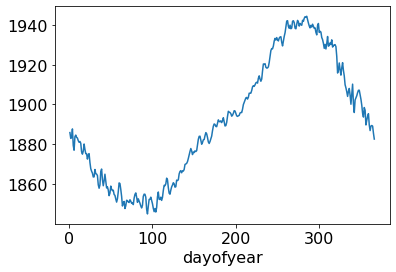

In [5]:
global_seasonality = (ds
    .to_array(dim='tide_gauge')
    .groupby('time.dayofyear').mean()
    .mean(dim='tide_gauge')
)

global_seasonality.plot()

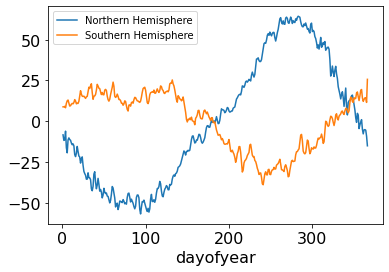

In [6]:
# Control for northern and southern hemispheres
NH_gauges = []
SH_gauges = []
for gauge, timeseries in ds.items():
    if timeseries.latitude > 0:
        NH_gauges.append(gauge)
    else:
        SH_gauges.append(gauge)

NH_ds = ds[NH_gauges]
SH_ds = ds[SH_gauges]


fig, ax = plt.subplots()

NH_avg_seasonality = (NH_ds
    .to_array(dim='tide_gauge')
    .groupby('time.dayofyear').mean()
    .mean(dim='tide_gauge')
)
NH_avg_seasonality = NH_avg_seasonality - NH_avg_seasonality.mean()

SH_avg_seasonality = (SH_ds
    .to_array(dim='tide_gauge')
    .groupby('time.dayofyear').mean()
    .mean(dim='tide_gauge')
    - SH_ds.to_array(dim='tide_gauge').mean()
)
SH_avg_seasonality = SH_avg_seasonality - SH_avg_seasonality.mean()

NH_avg_seasonality.plot(ax=ax, label='Northern Hemisphere')
SH_avg_seasonality.plot(ax=ax, label='Southern Hemisphere')

ax.legend(fontsize=10)

## Compute anomalies

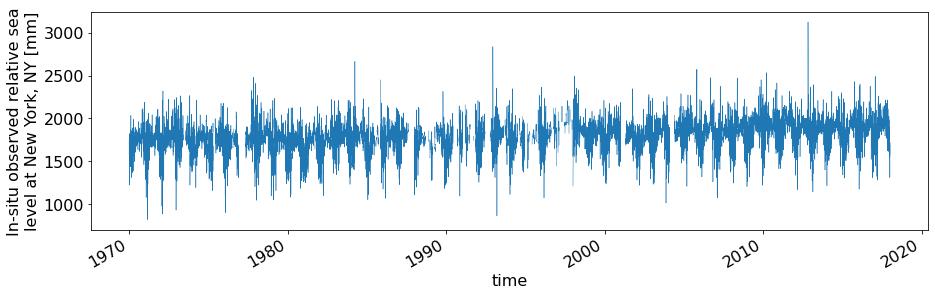

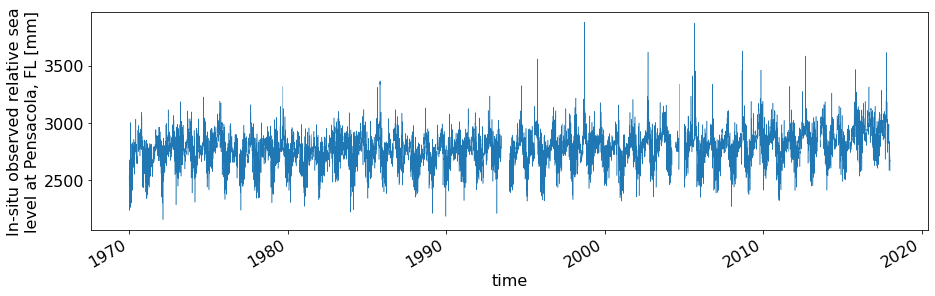

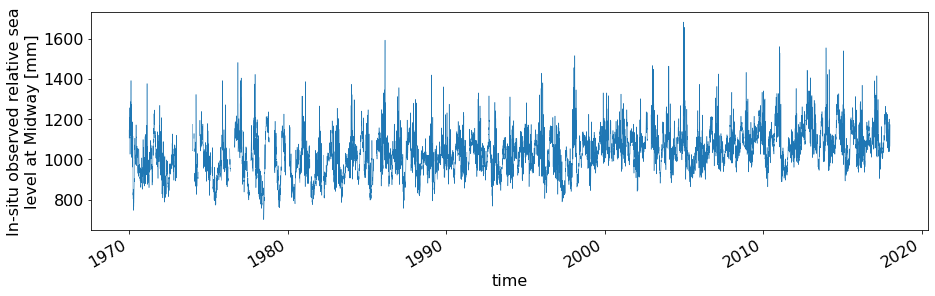

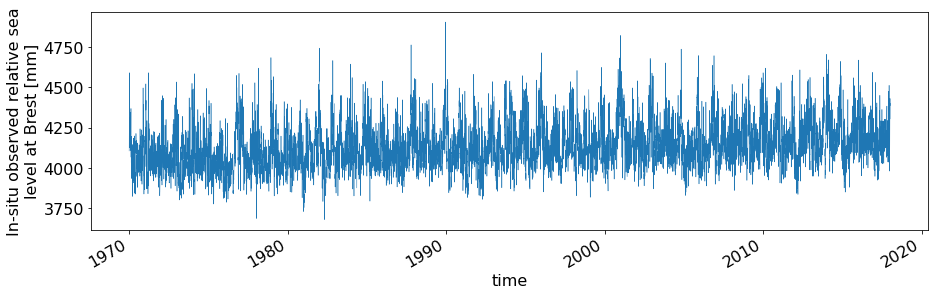

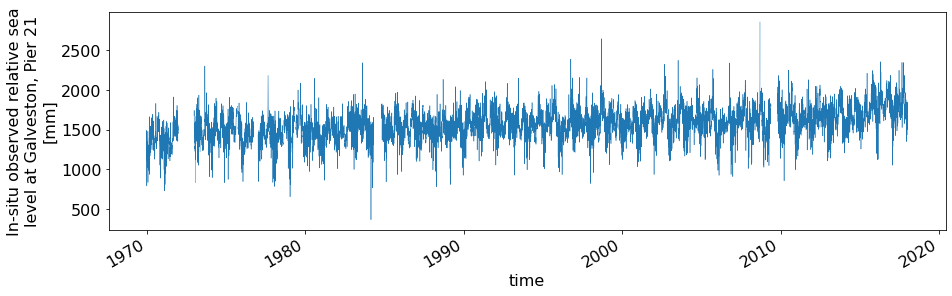

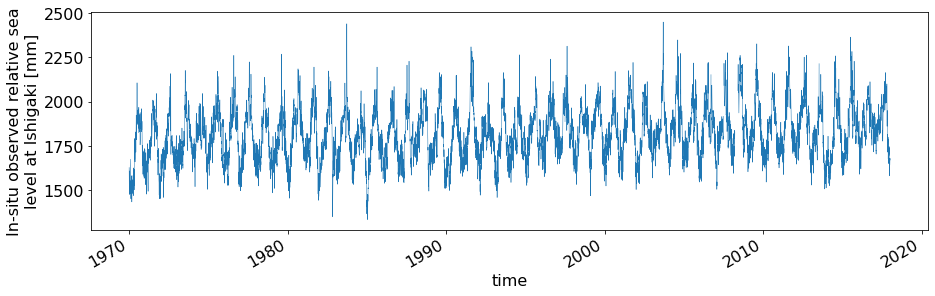

In [7]:
for gauge, timeseries in subset_ds.items():
    fig, ax = plt.subplots(figsize=(15,4));
    timeseries.plot(ax=ax, lw=0.5);

In [8]:
def compute_seasonality(darray):
    seasonality = darray.groupby('time.dayofyear').mean().rolling(dayofyear=30, center=True, min_periods=1).mean()
    return seasonality

def compute_anomaly(darray):
    anom = darray.groupby('time.dayofyear') - compute_seasonality(darray)
    return anom.drop_vars('dayofyear')

In [9]:
%%time
anom_ds = compute_anomaly(ds)

CPU times: user 10.5 s, sys: 106 ms, total: 10.6 s
Wall time: 10.7 s


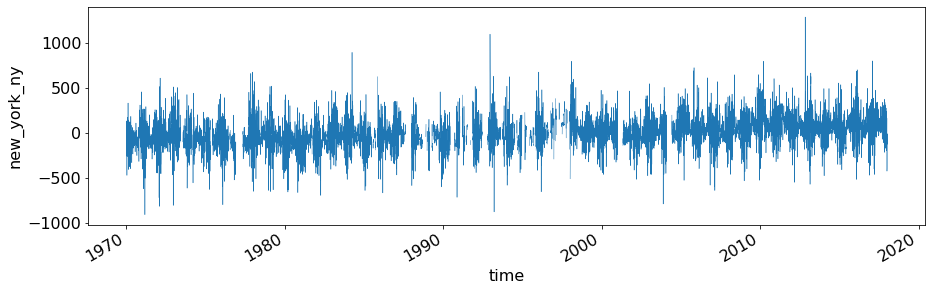

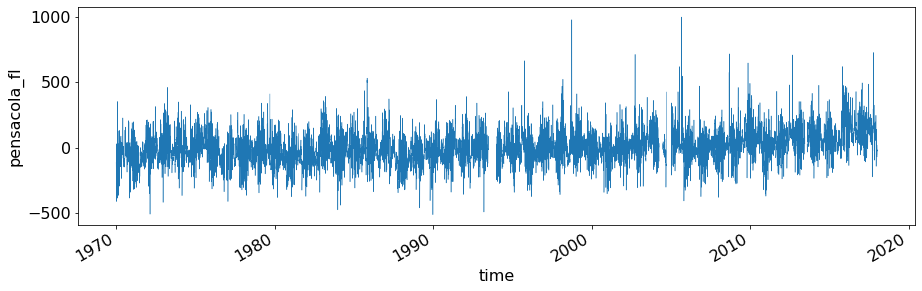

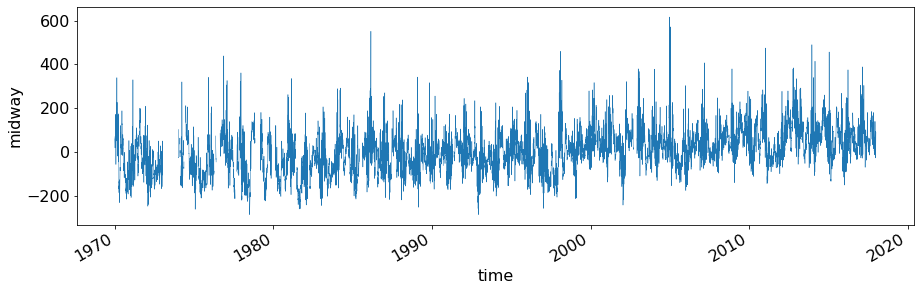

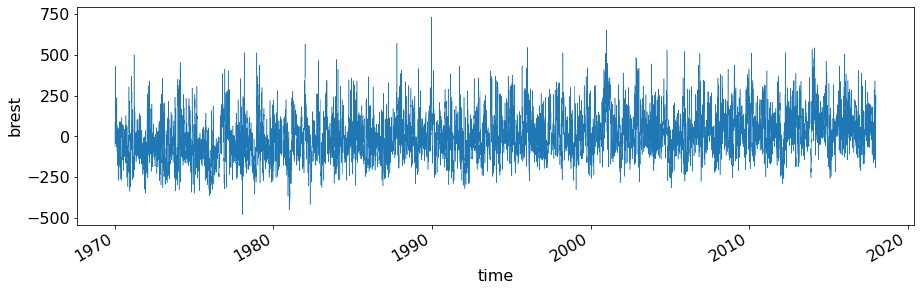

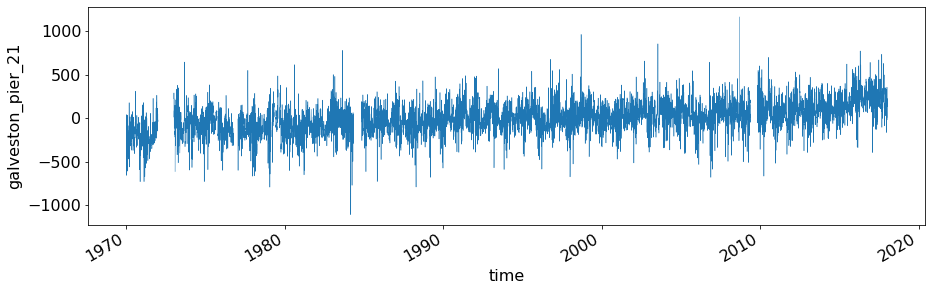

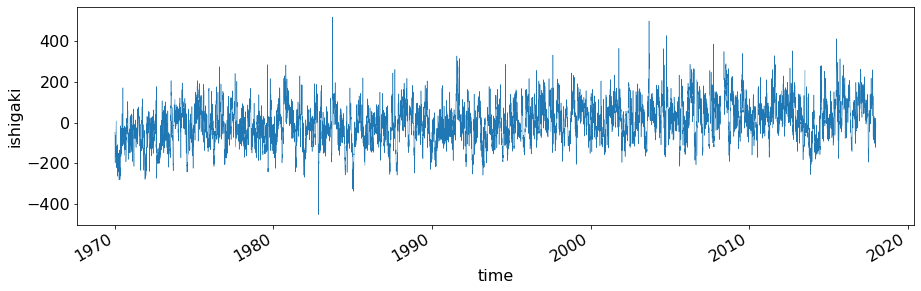

In [10]:
for gauge, timeseries in anom_ds[subset_gauges].items():
    fig, ax = plt.subplots(figsize=(15,4))
    timeseries.plot(ax=ax, lw=0.5)

## Compute ratios

In [11]:
%%time
gauges_list = list(ds.keys())
ratios = np.empty_like(gauges_list, dtype=float)
for i, gauge in enumerate(gauges_list):
    seasonality_avg = compute_seasonality(ds[gauge]).std(dim='dayofyear').item()
    anom_avg = anom_ds[gauge].std(dim='time').item()
    ratios[i] = anom_avg / seasonality_avg

CPU times: user 5.66 s, sys: 45 ms, total: 5.7 s
Wall time: 5.76 s


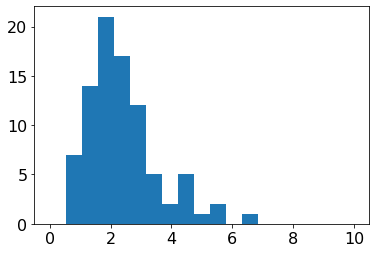

In [12]:
plt.hist(ratios, bins=np.linspace(0, 10, 20));

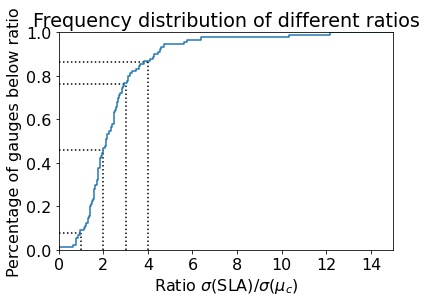

In [13]:
# Plot proportion of tide gauges less than a threshold
fig, ax = plt.subplots()
ax.step(np.sort(np.append(ratios, [0, 15])), np.linspace(0, 1, len(ratios)+2), ls='-');
ax.set(
    title='Frequency distribution of different ratios',
    xlabel=r'Ratio $\sigma($SLA$) / \sigma({\mu_c})$',
    ylabel='Percentage of gauges below ratio',
    xlim=(0,15),
    ylim=(0,1),
    xticks=np.arange(0,16,2)
);

for r in [1, 2, 3, 4]:
    p = len(ratios[ratios < r]) / len(ratios)
    ax.vlines(r, 0, p, ls=':', color='k')
    ax.hlines(p, 0, r, ls=':', color='k')


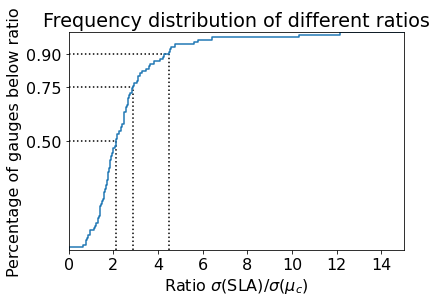

In [14]:
# Plot proportion of tide gauges less than a threshold
fig, ax = plt.subplots()
ax.step(np.sort(np.append(ratios, [0, 15])), np.linspace(0, 1, len(ratios)+2), ls='-');
ax.set(
    title='Frequency distribution of different ratios',
    xlabel=r'Ratio $\sigma($SLA$) / \sigma({\mu_c})$',
    ylabel='Percentage of gauges below ratio',
    xlim=(0,15),
    ylim=(0,1),
    xticks=np.arange(0,16,2)
);

for p in [0.5, 0.75, 0.9]:
    r = np.sort(ratios)[int(p * len(ratios))]
    ax.vlines(r, 0, p, ls=':', color='k')
    ax.hlines(p, 0, r, ls=':', color='k')

ax.set(yticks=[0.5, 0.75, 0.9]);

75% of tide gauges have seasonal cycles which are at least 1/3 of the std deviations of the anomalies.

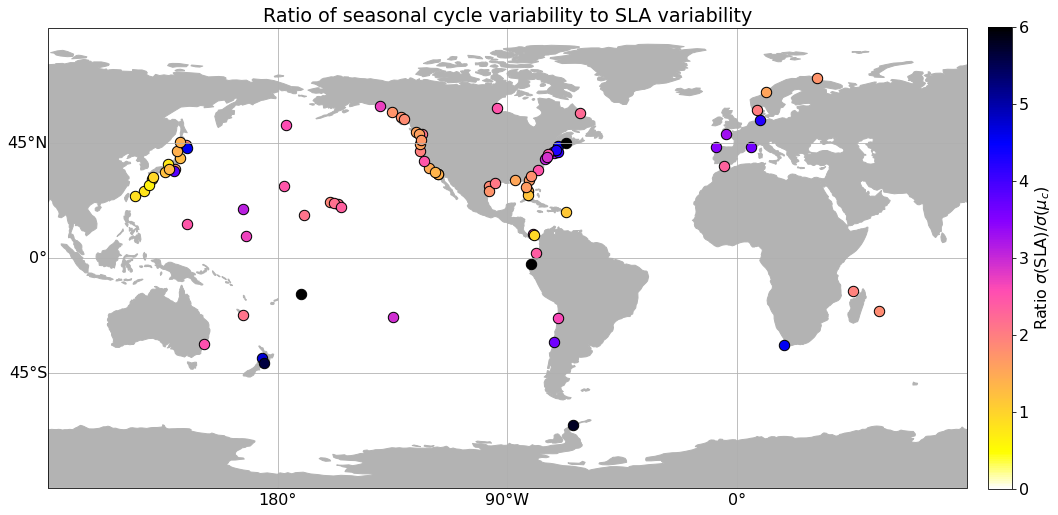

In [15]:
fig, ax = plt.subplots(
    figsize=(15,8),
    subplot_kw={'projection' : ccrs.PlateCarree(central_longitude=-90)}
)

lats = [ds[gauge].latitude for gauge in ds.keys()]
lons = [ds[gauge].longitude for gauge in ds.keys()]

# Plot
for lat, lon, color in zip(lats, lons, ratios):
    cax = ax.scatter(
        lon, lat,
        c=color, cmap='gnuplot2_r', vmin=0, vmax=6,
        marker='o', s=108, edgecolor='k',
        transform=ccrs.PlateCarree(),
    )

# Plot features
ax.set_global()
ax.add_feature(cartopy.feature.LAND, color=(0.7,0.7,0.7))
gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-270, 90, 90))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 45))
gl.top_labels = False

# Colorbar
cb = plt.colorbar(cax, ax=ax, fraction=0.024, pad=0.022)
cb.set_label(r'Ratio $\sigma($SLA$) / \sigma({\mu_c})$')

# Axis properties
ax.set(
    title='Ratio of seasonal cycle variability to SLA variability',
    xlabel='Longitude',
    ylabel='Latitude'
)

fig.tight_layout()

## Repeat analysis for seasonal data

In [16]:
ds_JJA = ds.where(ds.time.dt.season=='JJA', drop=True)
ds_DJF = ds.where(ds.time.dt.season=='DJF', drop=True)

anom_ds_JJA = anom_ds.where(anom_ds.time.dt.season=='JJA', drop=True)
anom_ds_DJF = anom_ds.where(anom_ds.time.dt.season=='DJF', drop=True)

In [17]:
%%time
ratios_JJA = np.empty_like(gauges_list, dtype=float)
ratios_DJF = np.empty_like(gauges_list, dtype=float)

for i, gauge in enumerate(gauges_list):
    # JJA
    seasonality_avg = compute_seasonality(ds_JJA[gauge]).std(dim='dayofyear').item()
    anom_avg = anom_ds_JJA[gauge].std(dim='time').item()
    ratios_JJA[i] = anom_avg / seasonality_avg
    
    # DJF
    seasonality_avg = compute_seasonality(ds_DJF[gauge]).std(dim='dayofyear').item()
    anom_avg = anom_ds_DJF[gauge].std(dim='time').item()
    ratios_DJF[i] = anom_avg / seasonality_avg

CPU times: user 2.87 s, sys: 27.1 ms, total: 2.9 s
Wall time: 2.93 s


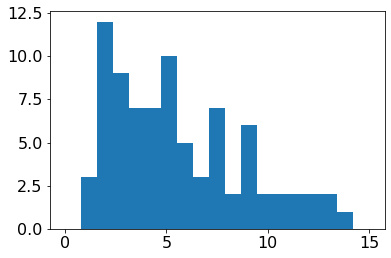

In [18]:
plt.hist(ratios_JJA, bins=np.linspace(0,15,20));

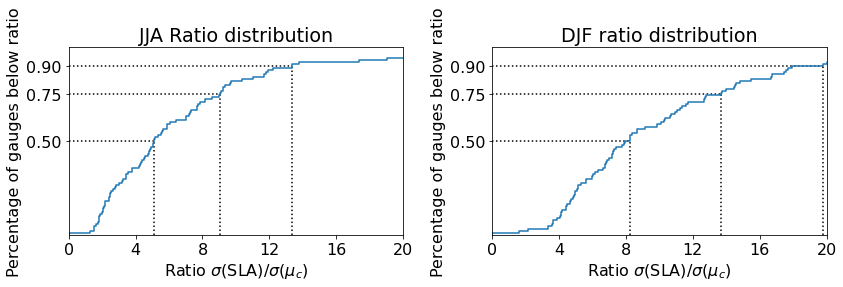

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4));

for i, ratios in enumerate([ratios_JJA, ratios_DJF]):
    axes[i].step(np.sort(np.append(ratios, [0, 30])), np.linspace(0, 1, len(ratios)+2), ls='-');
    axes[i].set(
        title='Frequency distribution of different ratios',
        xlabel=r'Ratio $\sigma($SLA$) / \sigma({\mu_c})$',
        ylabel='Percentage of gauges below ratio',
        xlim=(0,20),
        ylim=(0,1),
        xticks=np.arange(0,21,4)
    );

    for p in [0.5, 0.75, 0.9]:
        r = np.sort(ratios)[int(p * len(ratios))]
        axes[i].vlines(r, 0, p, ls=':', color='k');
        axes[i].hlines(p, 0, r, ls=':', color='k');

    axes[i].set(yticks=[0.5, 0.75, 0.9]);
    
axes[0].set_title('JJA Ratio distribution');
axes[1].set_title('DJF ratio distribution');

fig.tight_layout()

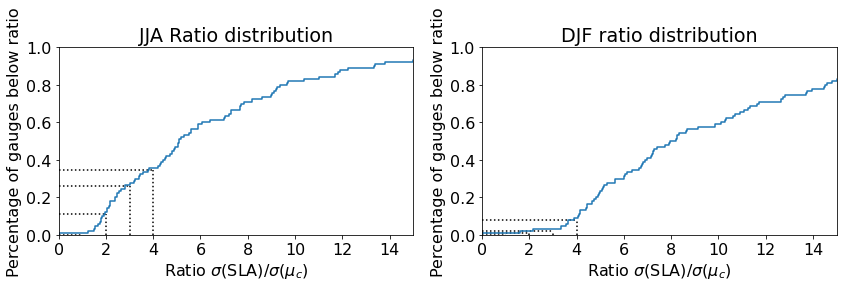

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4));

for i, ratios in enumerate([ratios_JJA, ratios_DJF]):
    axes[i].step(np.sort(np.append(ratios, [0, 15])), np.linspace(0, 1, len(ratios)+2), ls='-');
    axes[i].set(
        title='Frequency distribution of different ratios',
        xlabel=r'Ratio $\sigma($SLA$) / \sigma({\mu_c})$',
        ylabel='Percentage of gauges below ratio',
        xlim=(0,15),
        ylim=(0,1),
        xticks=np.arange(0,16,2)
    );

    for r in [1, 2, 3, 4]:
        p = len(ratios[ratios < r]) / len(ratios)
        axes[i].vlines(r, 0, p, ls=':', color='k')
        axes[i].hlines(p, 0, r, ls=':', color='k')
    
axes[0].set_title('JJA Ratio distribution');
axes[1].set_title('DJF ratio distribution');

fig.tight_layout();